In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, os, csv, io, re, datetime
import seaborn as sns

#Use functions from inflation_analysis.py
from Inflation_Analysis import find, mask, calc_inc_rates, \
calc_cost_rates, median_mean, gini, cpi_calc

from big_mac_index import clean_and_filter

%matplotlib inline

#### The next several cells are used for importing data from various sources and storing the data in Pandas DataFrames

In [157]:
filepath = '/home/dhense/PublicData/Economic_analysis/'
cx_pickle = 'cx.pickle'
cps_pickle = 'cps.pickle'
cpsp_pickle = 'cpsp.pickle'
saipe_pickle = 'saipe.pickle'

#Import Consumer Expenditure Data
print("...loading pickle")
tmp = open(filepath+'intermediate_files/'+cx_pickle,'rb')
df_cx = pickle.load(tmp)
tmp.close()

#Import Current Population Survey Household-Level Data
print("...loading pickle")
tmp = open(filepath+'intermediate_files/'+cps_pickle,'rb')
df_cps = pickle.load(tmp)
tmp.close()

#Import Current Population Survey Person-Level Data
print("...loading pickle")
tmp = open(filepath+'intermediate_files/'+cpsp_pickle,'rb')
df_cpsp = pickle.load(tmp)
tmp.close()

#Import SAIPE Data
print("...loading pickle")
tmp = open(filepath+'intermediate_files/'+saipe_pickle,'rb')
df_saipe = pickle.load(tmp)
tmp.close()

...loading pickle
...loading pickle
...loading pickle
...loading pickle


In [158]:
#Import detailed consumer expenditure interview survey data
df_ce1 = pd.read_csv('/home/dhense/PublicData/ce_survey/interviews/2018/intrvw18/fmli181x.csv')
df_ce2 = pd.read_csv('/home/dhense/PublicData/ce_survey/interviews/2018/intrvw18/fmli182.csv')
df_ce3 = pd.read_csv('/home/dhense/PublicData/ce_survey/interviews/2018/intrvw18/fmli183.csv')
df_ce4 = pd.read_csv('/home/dhense/PublicData/ce_survey/interviews/2018/intrvw18/fmli184.csv')
df_ce5 = pd.read_csv('/home/dhense/PublicData/ce_survey/interviews/2018/intrvw18/fmli191.csv')

df_ce = pd.concat([df_ce1,df_ce2,df_ce3,df_ce4,df_ce5])

df_ce = df_ce[df_ce['QINTRVYR']==2018]
df_ce = df_ce[df_ce['TOTEXPPQ']>0]
df_ce = df_ce[df_ce['HEALTHPQ']>=0]
df_ce = df_ce[df_ce['FOODPQ']>=0]
df_ce = df_ce[df_ce['HOUSPQ']>=0]
df_ce = df_ce[df_ce['TRANSPQ']>=0]

In [190]:
#Import GDP Growth Rate and S&P 500 Growth Rate Data
df_gdp = pd.read_csv('Data/united-states-gdp-growth-rate.csv')
df_sp500 = pd.read_excel('Data/shiller_market_data.xls','Data',skiprows=7)

df_gdp['year'] = pd.to_datetime(df_gdp['date']).dt.year
df_sp500['year'] = df_sp500['Date'].astype(str).str[:4]
total_return = df_sp500[1584:1776][['Price.1','year']]
total_return = total_return.groupby('year')['Price.1'].mean()

#Calculate Growth Rate for S&P 500 Real Total Return Prices
return_rates = []
for i in range(len(total_return.values)-1):
    return_rates.append(((total_return.values[i+1]\
                          /total_return.values[i])-1)*100)

In [222]:
#Import Federal Reserve Real Median Household Income data
df_fred = pd.read_excel('Data/FRED_med_inc.xlsx',encoding='latin-1')
df_fred = df_fred.rename(columns={'observation_date':'year','MEHOINUSA672N':'Real_Median_HH_Income'})
df_fred['year'] = pd.DatetimeIndex(df_fred['year']).year

df_fred = df_fred[df_fred.year>1988]

#Import CPI data used in calculation of real rates 
df_cpi = pd.read_excel('Data/cpi-u-rs.xlsx',encoding='latin-1',skiprows=6)
inflation_dict, inflation_list = cpi_calc(df_cpi,1989,2018)

#Calculate Nominal figures
nominal_incs = []
for yr in range(1989,2019):
    nominal_incs.append(int(df_fred[df_fred.year==yr]['Real_Median_HH_Income'].values[0]/inflation_dict[yr]))

df_fred['Nominal_Median_HH_Income'] = nominal_incs
df_fred.head()

,year,Real_Median_HH_Income,Nominal_Median_HH_Income
1,1989,56678,28906
2,1990,55952,29942
3,1991,54318,30126
4,1992,53897,30635
5,1993,53610,31241


In [163]:
#Import big mac index data
fp = 'Data/'
bigmac_pickle = 'bigmac.pickle'

print("...loading pickle")
tmp = open(fp+bigmac_pickle,'rb')
df = pickle.load(tmp)
tmp.close()

bmi_vals = clean_and_filter(df,1988,2019)

...loading pickle


#### Analysis is limited to inelastic goods and services. We will start by looking broadly at quarterly household spending on items within the following categories: Housing, Healthcare, Food and Transportation

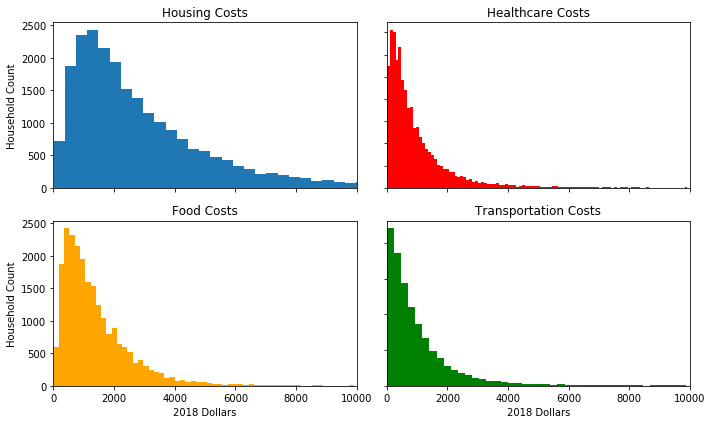

In [164]:
# Plot distribution of quarterly spending on items in different cost categories in 2018
fig, ax = plt.subplots(2,2, figsize=(10,6))

ax[0,0].hist(df_ce[df_ce['HOUSPQ']>0]['HOUSPQ'],bins=500)
ax[0,1].hist(df_ce[df_ce['HEALTHPQ']>0]['HEALTHPQ'],bins=200,color='red')
ax[1,0].hist(df_ce[df_ce['FOODPQ']>0]['FOODPQ'],bins=200, color='orange')
ax[1,1].hist(df_ce[df_ce['TRANSPQ']>0]['TRANSPQ'],bins=500, color='green')

title_list = ['Housing Costs','Healthcare Costs','Food Costs','Transportation Costs']

for i in range(0,2):
    for x in range(0,2):
        ax[i,x].set_xlim(0,10000)
        ax[i,x].set_title(title_list[2*i+x])

for x in ax.flat:
    x.set(xlabel='2018 Dollars', ylabel='Household Count')
    x.label_outer()

plt.tight_layout()

In [165]:
df_ce_cats = df_ce[['HOUSPQ','FOODPQ','TRANSPQ','HEALTHPQ']].stack()\
.reset_index().rename(columns={'level_1':'Category',0:'Values'})\
[['Category','Values']]

df_ce_cats['Category'] = df_ce_cats['Category'].replace({'HOUSPQ':'HOUSING',\
'FOODPQ':'FOOD','TRANSPQ':'TRANSPORTATION','HEALTHPQ':'HEALTHCARE'})

df_ce_cats.head()

,Category,Values
0,HOUSING,5712.0
1,FOOD,4255.0
2,TRANSPORTATION,3202.0
3,HEALTHCARE,1560.0
4,HOUSING,2589.0


Text(0.5, 1, 'Distribution of Household Spending by Category (2018)')

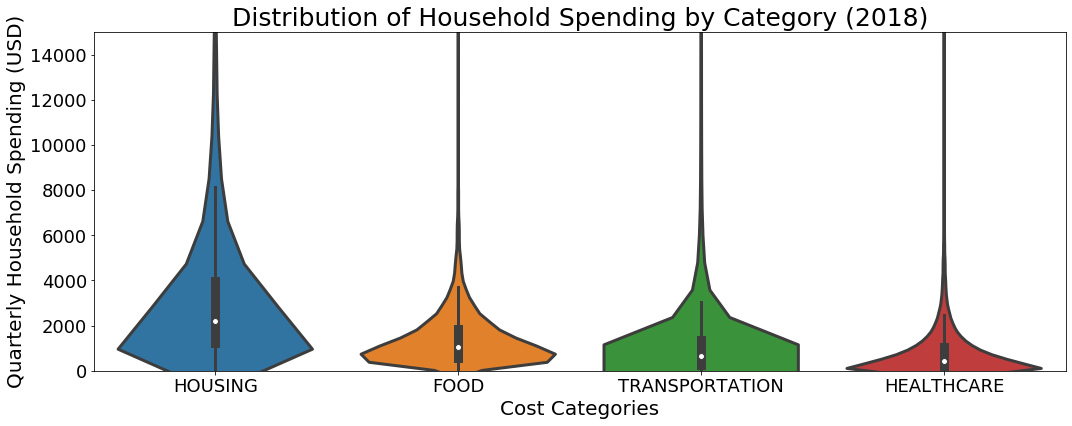

In [166]:
fig = plt.subplots(figsize=(15,6))
ax = sns.violinplot(x='Category', y='Values', hue='Category', dodge=False, data=df_ce_cats, linewidth=3)

ax.set_xlabel('Cost Categories', fontsize=20)
ax.set_ylabel('Quarterly Household Spending (USD)', fontsize=20)
ax.tick_params(labelsize=18)
ax.legend().set_visible(False)

ax.set_ylim(0,15000)
plt.tight_layout()
plt.title('Distribution of Household Spending by Category (2018)', fontsize=25)

In [221]:
df_perc = df_ce
df_perc = df_perc[df_perc['HEALTHPQ']>0]
df_perc = df_perc[df_perc['FOODPQ']>0]
df_perc = df_perc[df_perc['HOUSPQ']>0]
df_perc = df_perc[df_perc['TRANSPQ']>0]

df_perc['Housing'] = df_perc['HOUSPQ']/df_perc['TOTEXPPQ']
df_perc['Food'] = df_perc['FOODPQ']/df_perc['TOTEXPPQ']
df_perc['Healthcare'] = df_perc['HEALTHPQ']/df_perc['TOTEXPPQ']
df_perc['Transportation'] = df_perc['TRANSPQ']/df_perc['TOTEXPPQ']

df_ce_perc = df_perc[['Housing','Food','Transportation','Healthcare']]\
.stack().reset_index().rename(columns={'level_1':'Category',0:'Values'})[['Category','Values']]

df_ce_perc.head()

,Category,Values
0,Housing,0.285370
1,Food,0.212579
2,Transportation,0.159971
3,Healthcare,0.077937
4,Housing,0.221820


Text(0.5, 1, 'Distribution of Household Spending Percentages by Category (2018)')

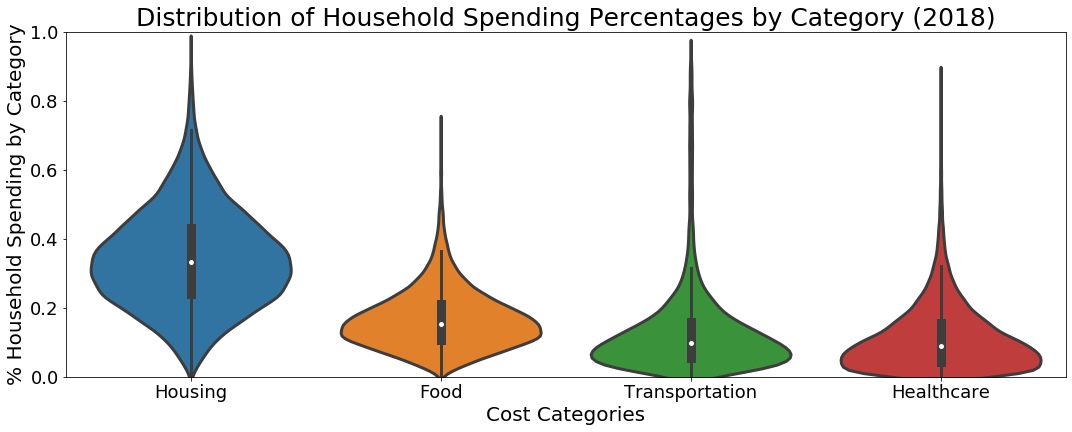

In [205]:
#Get rid of all rows where any of these values are less than 0?

fig = plt.subplots(figsize=(15,6))
ax = sns.violinplot(x='Category', y='Values', hue='Category', dodge=False, data=df_ce_perc, linewidth=3)

ax.set_xlabel('Cost Categories', fontsize=20)
ax.set_ylabel('% Household Spending by Category', fontsize=20)
ax.tick_params(labelsize=18)

ax.legend().set_visible(False)

ax.set_ylim(0,1)
plt.tight_layout()
plt.title('Distribution of Household Spending Percentages by Category (2018)', fontsize=25)

In [206]:
df_perc = pd.DataFrame()
df_perc['Category'] = df_ce_perc.groupby('Category')['Values'].mean().index
df_perc['Mean_Percentage'] = [str(df_ce_perc.groupby('Category')['Values'].mean()\
                             .values.round(3)[i]*100)[0:4]+'%' for i in range(4)]
df_perc['25th_Percentile'] = [str(df_ce_perc.groupby('Category').quantile(.25)\
                             .values.round(3)[i]*100)[1:-1]+'%' for i in range(4)]
df_perc['75th_Percentile'] = [str(df_ce_perc.groupby('Category').quantile(.75)\
                             .values.round(3)[i]*100)[1:-1]+'%' for i in range(4)]

df_perc = df_perc.T
df_perc = df_perc.rename(columns=df_perc.iloc[0]).iloc[1:]

#Print table with centered values
d = dict(selector="th",
    props=[('text-align', 'center')])

df_perc.style.set_properties(**{'text-align':'center'})\
        .set_table_styles([d])

,Food,Healthcare,Housing,Transportation
Mean_Percentage,16.7%,11.3%,34.2%,13.1%
25th_Percentile,10.8%,4.4%,24.1%,5.5%
75th_Percentile,21.1%,15.5%,43.1%,15.9%


#### Now that we have a sense for the distributions and median values for the four categories of goods/services, let's calculate inlfation figures based on these costs and percentages of household spending. Code for these calculations can be found in Inflation_Analysis.py

In [169]:
#CX: Limit to middle 20% of population
totals = df_cx[(df_cx['demographics_code']=='LB01')&(df_cx['characteristics_code']=='04')]

#CX: Set years and variables
years = range(1989,2019)
cat_codes = ['HOUSING','TRANS','FOODTOTL','HEALTH']
total_exp = 'TOTALEXP'

#Calculate category cost rates
cost_rates, cost_list, year_dict = calc_cost_rates(totals, years, cat_codes, total_exp)

$$
\underline{Equation\ 1}:\ Yearly\ Cost = \sum_{i=1}^n (Median\ Cost_i*Weight_i)\\
where\ i\ = Cost\ Category\ ,\ n\ = \#\ Categories\ and\ Weight_i = \frac{Median\ Cost\ Percentage_i}{\sum_{x=1}^n Median\ Cost\ Percentage_x}
$$

$$
\\
$$

$$
\underline{Equation\ 2}:\ Annual\ Inflation\ Rate  = \frac{Yearly\ Cost_i}{Yearly\ Cost_{i-1}}-1\\
where\ i\ = Year
$$

#### Let's try looking at a more granular list of categories of goods and services within the broad categories used above. Note - some of these subcategories show up as numbers and others as indecipherable acronyms.

In [170]:
totals_health = totals[totals['subcategory_code']=='HEALTH']['item_code'].unique()
totals_housing = totals[totals['subcategory_code']=='HOUSING']['item_code'].unique()
totals_food = totals[totals['subcategory_code']=='FOODTOTL']['item_code'].unique()
totals_trans = totals[totals['subcategory_code']=='TRANS']['item_code'].unique()

print('Housing Items: '+str([i for i in totals_housing])[1:-1]+'\n')
print('Healthcare Items: '+str([i for i in totals_health])[1:-1]+'\n')
print('Food Items: '+str([i for i in totals_food])[1:-1]+'\n')
print('Transportation Items: '+str([i for i in totals_trans])[1:-1]+'\n')

Housing Items: '220211', '270102', 'ELECTRIC', 'FLOORCOV', 'FURNITUR', 'HHFURNSH', 'HHOPER', 'HHOTHXPN', 'HHPERSRV', 'HHTXTILE', 'HKPGOTHR', 'HKPGSUPP', 'HOUSING', 'LAUNDRY', 'MAJAPPL', 'MISCHHEQ', 'NATRLGAS', 'OTHLODGE', 'OTHRFUEL', 'OWNDWELL', 'OWNEXPEN', 'OWNMORTG', 'PHONE', 'POSTAGE', 'RESPHONE', 'RNTDWELL', 'SHELTER', 'SMAPPHWR', 'UTILS', 'WATER'

Healthcare Items: 'DRUGS', 'HEALTH', 'HLTHINSR', 'MEDSERVS', 'MEDSUPPL'

Food Items: '080110', '190904', 'ANIMAL', 'BAKERY', 'BEEF', 'CERBAKRY', 'CEREAL', 'DAIRY', 'FATSOILS', 'FISHSEA', 'FOODAWAY', 'FOODHOME', 'FOODTOTL', 'FRESHVEG', 'FRSHFRUT', 'FRUITVEG', 'MILKCRM', 'MISCFOOD', 'NALCBEVG', 'OTHDAIRY', 'OTHRFOOD', 'OTHRMEAT', 'PORK', 'POULTRY', 'PROCFRUT', 'PROCVEG', 'SWEETS'

Transportation Items: '500110', 'CAREPAIR', 'GASOIL', 'NEWCARS', 'OTHVEHCL', 'PUBTRANS', 'TRANS', 'USEDCARS', 'VEHFINCH', 'VEHOTHXP', 'VEHPURCH', 'VEHRNTLC'



#### I've selected a list of subcategories based on their inelasticities using common sense. I've also added education, alcohol and tobacco into the list since these seem appropriately inelastic and consistent across time.

#### Adding another inflation metric which tracks the cost paid for rent over time (a growing segment of the US are renters and this trend is set to continue)

In [171]:
#Define subcategory items for additional inflation indices, calculate cost rates
item_codes_sub = ['DRUGS','MEDSERVS','MEDSUPPL','FOODHOME','GASOIL','USEDCARS','VEHOTHXP','PUBTRANS',\
              'SHELTER','UTILS','HHOPER','HKPGSUPP','ALCBEVG','EDUCATN','TOBACCO']
sub_cost_rates, sub_cost_list, sub_year_dict = calc_cost_rates(totals, years, item_codes_sub, total_exp)


rent_code = ['RNTDWELL']
rent_rates, rent_list, rent_year_dict = calc_cost_rates(totals, years, rent_code, total_exp)


#Calculate income growth rates from FRED nominal income data
inc_rates, inc_list  = calc_inc_rates(df_fred, years, ['Nominal_Median_HH_Income'])

/home/dhense/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dhense/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Using the annual inflation figures from the various indices calculated above, it is time to compare the associated real median household income values.

In [207]:
real_incomes_cat = []
real_incomes_sub = []
real_incomes_bmi = []
real_incomes_rent = []

for i in range(0,30):
    real_incomes_cat.append(df_fred['Nominal_Median_HH_Income'].values[i]*(cost_list[-1]/cost_list[i]))
    real_incomes_sub.append(df_fred['Nominal_Median_HH_Income'].values[i]*(sub_cost_list[-1]/sub_cost_list[i]))
    real_incomes_bmi.append(df_fred['Nominal_Median_HH_Income'].values[i]*(bmi_vals[-1]/bmi_vals[i]))
    real_incomes_rent.append(df_fred['Nominal_Median_HH_Income'].values[i]*(rent_list[-1]/rent_list[i]))

real_incomes_cpi = list(df_fred[df_fred.year>1988].reset_index()['Real_Median_HH_Income'])

df_real_incs = pd.DataFrame()
df_real_incs['Year'] = range(1989,2019)
df_real_incs['Category_Index'] = real_incomes_cat
df_real_incs['Subcategory_Index'] = real_incomes_sub
df_real_incs['Big_Mac_Index'] = real_incomes_bmi
df_real_incs['Rent_Index'] = real_incomes_rent
df_real_incs['CPI_U_RS'] = real_incomes_cpi

df_real_incs.head()

,Year,Category_Index,Subcategory_Index,Big_Mac_Index,Rent_Index,CPI_U_RS
0,1989,63781.407982,61615.367328,78847.554455,79672.062188,56678
1,1990,65562.239710,62612.035059,74991.100000,78022.093438,55952
2,1991,62634.652366,59621.823344,73775.226667,74735.364318,54318
3,1992,61601.530117,58745.468899,77077.100457,71765.993393,53897
4,1993,63183.653552,60843.041944,75499.083333,77154.390050,53610


Text(0.5, 1.0, 'Real Median Household Incomes Under Different Inflation Estimates')

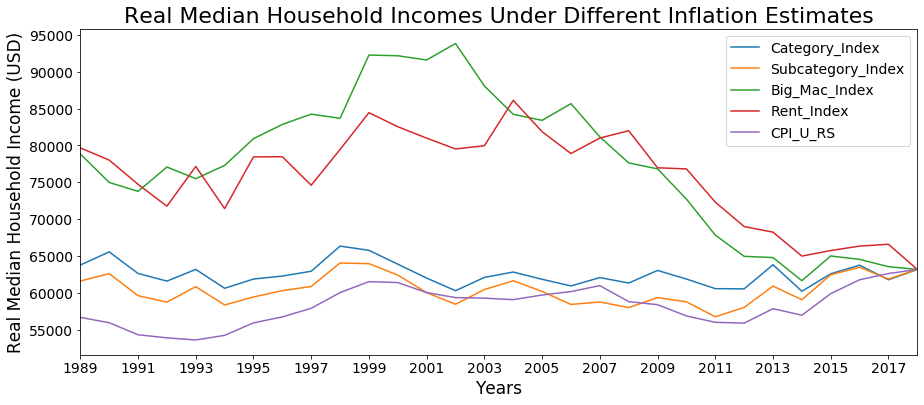

In [208]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(df_real_incs['Year'],df_real_incs['Category_Index'])
ax.plot(df_real_incs['Year'],df_real_incs['Subcategory_Index'])
ax.plot(df_real_incs['Year'],df_real_incs['Big_Mac_Index'])
ax.plot(df_real_incs['Year'],df_real_incs['Rent_Index'])
ax.plot(df_real_incs['Year'],df_real_incs['CPI_U_RS'])

ax.legend(['Category_Index','Subcategory_Index','Big_Mac_Index','Rent_Index','CPI_U_RS'], fontsize=14)

ax.set_xlabel('Years', fontsize=17)
ax.set_ylabel('Real Median Household Income (USD)', fontsize=17)
ax.tick_params(labelsize=14)

ax.set_xlim(1989,2018)
plt.xticks(np.arange(1989,2019,2))

plt.title('Real Median Household Incomes Under Different Inflation Estimates', fontsize=22)

#### Purchasing power for rent and big macs has plummetted since the early 2000's. The Median household income trend looks very bleak when using costs associated with these goods. The category and subcategory indices produce income figures much more in line with the CPI. Let's take a closer look. 

Text(0.5, 1.0, 'Real Median Household Incomes Under Different Inflation Estimates')

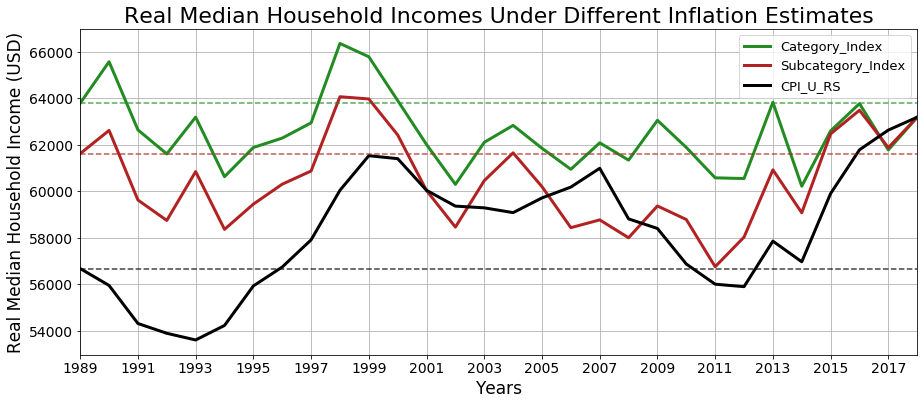

In [209]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(df_real_incs['Year'],df_real_incs['Category_Index'],color='forestgreen',linewidth=3)
ax.plot(df_real_incs['Year'],df_real_incs['Subcategory_Index'],color='firebrick',linewidth=3)
ax.plot(df_real_incs['Year'],df_real_incs['CPI_U_RS'],color='k',linewidth=3)

plt.axhline(y=df_real_incs['Category_Index'][0], color='forestgreen', linestyle='--',alpha=0.75)
plt.axhline(y=df_real_incs['Subcategory_Index'][0], color='firebrick', linestyle='--',alpha=0.75)
plt.axhline(y=df_real_incs['CPI_U_RS'][0], color='k', linestyle='--',alpha=0.75)

ax.set_xlim(1989,2018)
plt.xticks(np.arange(1989,2019,2))
ax.legend(['Category_Index','Subcategory_Index','CPI_U_RS'], fontsize=13)
plt.grid()

ax.set_xlabel('Years', fontsize=17)
ax.set_ylabel('Real Median Household Income (USD)', fontsize=17)
ax.tick_params(labelsize=14)

plt.title('Real Median Household Incomes Under Different Inflation Estimates', fontsize=22)

##### * Dashed lines correspond to 1989 Median Household Incomes under different inflation assumptions

#### While the CPI-calculated income figures show slight improvement over the past 30 years, the two category-calculated figures are completely stagnant.

In [210]:
real_inc_growth = pd.DataFrame()
yrs = []
cpi = []
cats = []
subcats = []
for i in range(5,35,5):
    yrs.append('Last '+str(i))
    cpi.append(str((((real_incomes_cpi[-1]/real_incomes_cpi[-i])**(1/i))-1)*100)[:4]+'%')
    cats.append(str((((real_incomes_cat[-1]/real_incomes_cat[-i])**(1/i))-1)*100)[:4]+'%')
    subcats.append(str((((real_incomes_sub[-1]/real_incomes_sub[-i])**(1/i))-1)*100)[:4]+'%')
    
real_inc_growth['Years'] = yrs
real_inc_growth['CPI'] = cpi
real_inc_growth['Category_Index'] = cats
real_inc_growth['Subcategory_Index'] = subcats

#Print table with centered values
d = dict(selector="th",
    props=[('text-align', 'center')])

real_inc_growth.style.set_properties(**{'text-align':'center'})\
        .set_table_styles([d])

,Years,CPI,Category_Index,Subcategory_Index
0,Last 5,2.09%,0.96%,1.35%
1,Last 10,0.78%,0.02%,0.62%
2,Last 15,0.44%,0.03%,0.16%
3,Last 20,0.13%,-0.2%,-0.0%
4,Last 25,0.61%,0.16%,0.31%
5,Last 30,0.36%,-0.0%,0.08%


#### The final part of this analysis will show how growth in Median Household Incomes and a few of it's components compare with growth in the S&P 500 and the US GDP, using the subcategories index as the underlying inflation metric.

#### The income components we will look at are Wage/Salary Income and Government Payment Income (including child support, unemployment compensation, etc.. these are all listed in the cell below).

In [179]:
df_cps = df_cps.fillna(0)
df_cps=df_cps.rename(columns={'Year':'year'}).astype(int)
df_cps['Government_Payments'] = df_cps['Child_Support']+df_cps['Disability']+df_cps['Financial_Assistance']+\
                                  df_cps['Public_Assistance']+df_cps['Retirement_Income']+df_cps['Social_Security']+\
                                  df_cps['Supplemental_Security']+df_cps['Unemployment_comp']

In [225]:
df_cps_agg = pd.DataFrame()
df_cps_agg['year'] = [i for i in range(2003,2020)]

incomes = ['HH_Income','Wages_Salaries','Government_Payments']
for inc in incomes:
    if inc == 'Wages_Salaries':
        df_cps_agg[inc] = df_cps[df_cps['HINC_WS']==1].groupby('year')[inc].median().values
    elif inc == 'HH_Income':
        df_cps_agg[inc] = df_cps.groupby('year')['HH_Income'].median().values
    else:
        df_cps_agg[inc] = df_cps[df_cps[inc]!=0].groupby('year')[inc].median().values

#Get rid of 2019
df_cps_agg = df_cps_agg[:-1]
df_cps_agg.head()

,year,HH_Income,Wages_Salaries,Government_Payments
0,2003,44231.0,45500.0,10248
1,2004,45100.0,46221.0,10476
2,2005,46324.0,48000.0,11076
3,2006,48078.0,50000.0,11738
4,2007,50002.0,50200.0,12000


In [226]:
#Nominal Median Income rates 2004-2018
hhinc_rates = []
wage_rates = []
govt_rates = []
for yr in range(2004,2019):
    hhinc_rates.append(df_cps_agg[df_cps_agg.year==yr]['HH_Income'].astype(float).values[0]\
                      /df_cps_agg[df_cps_agg.year==yr-1]['HH_Income'].astype(float).values[0])
    wage_rates.append(df_cps_agg[df_cps_agg.year==yr]['Wages_Salaries'].astype(float).values[0]\
                      /df_cps_agg[df_cps_agg.year==yr-1]['Wages_Salaries'].astype(float).values[0])
    govt_rates.append(df_cps_agg[df_cps_agg.year==yr]['Government_Payments'].astype(float).values[0]\
                      /df_cps_agg[df_cps_agg.year==yr-1]['Government_Payments'].astype(float).values[0])

hhinc_rates = (np.array(hhinc_rates)-1.0)*100
wage_rates = (np.array(wage_rates)-1.0)*100
govt_rates = (np.array(govt_rates)-1.0)*100

In [227]:
print('Nominal HH Income Annual %% Increase: %.2f%%' % (np.mean(hhinc_rates)))
print('Nominal Wages Annual %% Increase: %.2f%%' % (np.mean(wage_rates)))
print('Nominal Govt Payments Annual %% Increase: %.2f%%' % (np.mean(govt_rates)))

Nominal HH Income Annual % Increase: 2.27%
Nominal Wages Annual % Increase: 2.43%
Nominal Govt Payments Annual % Increase: 3.60%


In [229]:
#Real figures
cost_rate_list = sub_cost_list[-16:]

real_incomes = []
real_wages = []
real_govt = []


for i in range(0,16):
    real_incomes.append(df_cps_agg['HH_Income'].values[i]*(sub_cost_list[-1]/cost_rate_list[i]))
    real_wages.append(df_cps_agg['Wages_Salaries'].values[i]*(sub_cost_list[-1]/cost_rate_list[i]))
    real_govt.append(df_cps_agg['Government_Payments'].values[i]*(sub_cost_list[-1]/cost_rate_list[i]))
    


df_cps_agg['Real_HH_Income']=real_incomes
df_cps_agg['Real_Wages_Salaries']=real_wages
df_cps_agg['Real_Government_Payments']=real_govt


df_cps_agg.head()

,year,HH_Income,Wages_Salaries,Government_Payments,Real_HH_Income,Real_Wages_Salaries,Real_Government_Payments
0,2003,44231.0,45500.0,10248,61728.281282,63499.283270,14301.992417
1,2004,45100.0,46221.0,10476,62714.849797,64273.682317,14567.644489
2,2005,46324.0,48000.0,11076,60193.078917,62370.861497,14392.076291
3,2006,48078.0,50000.0,11738,58286.487969,60616.589677,14230.350592
4,2007,50002.0,50200.0,12000,58499.451952,58731.100516,14039.306896


In [230]:
#Real Median Income rates 2004-2018
real_hhinc_rates = []
real_wage_rates = []
real_govt_rates = []
for yr in range(2004,2019):
    real_hhinc_rates.append(df_cps_agg[df_cps_agg.year==yr]['Real_HH_Income'].astype(float).values[0]\
                      /df_cps_agg[df_cps_agg.year==yr-1]['Real_HH_Income'].astype(float).values[0])
    real_wage_rates.append(df_cps_agg[df_cps_agg.year==yr]['Real_Wages_Salaries'].astype(float).values[0]\
                      /df_cps_agg[df_cps_agg.year==yr-1]['Real_Wages_Salaries'].astype(float).values[0])
    real_govt_rates.append(df_cps_agg[df_cps_agg.year==yr]['Real_Government_Payments'].astype(float).values[0]\
                      /df_cps_agg[df_cps_agg.year==yr-1]['Real_Government_Payments'].astype(float).values[0])
    

real_hhinc_rates = (np.array(real_hhinc_rates)-1.0)*100
real_wage_rates = (np.array(real_wage_rates)-1.0)*100
real_govt_rates = (np.array(real_govt_rates)-1.0)*100

In [231]:
print('Real HH Income Annual %% Increase: %.2f%%' % (np.mean(real_hhinc_rates)))
print('Real Wages Annual %% Increase: %.2f%%' % (np.mean(real_wage_rates)))
print('Real Govt Payments Annual %% Increase: %.2f%%' % (np.mean(real_govt_rates)))
print('Real GDP Growth Rate: %.2f%%' % np.mean(df_gdp['GDP Growth (%)'].values[-15:]))

Real HH Income Annual % Increase: 0.04%
Real Wages Annual % Increase: 0.20%
Real Govt Payments Annual % Increase: 1.35%
Real GDP Growth Rate: 1.97%


Text(0.5, 1.0, 'Percent Change Income Components vs. GDP Using Subcategory Inflation Index')

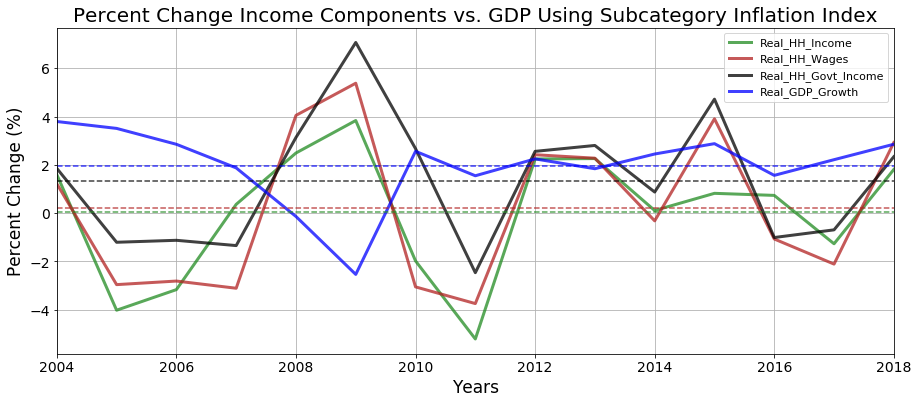

In [187]:
fig, ax = plt.subplots(figsize=(15,6))

years = [i for i in range(2004,2019)]

ax.plot(years, real_hhinc_rates, color='forestgreen',alpha=0.75, linewidth=3)
ax.plot(years, real_wage_rates, color='firebrick',alpha=0.75, linewidth=3)
ax.plot(years, real_govt_rates, color='k',alpha=0.75, linewidth=3)

ax.plot(years, df_gdp['GDP Growth (%)'].values[-15:], color='blue',alpha=0.75, linewidth=3)

#Plot means as dashed lines
plt.axhline(y=np.mean(real_hhinc_rates), color='forestgreen', linestyle='--',alpha=0.75)
plt.axhline(y=np.mean(real_wage_rates), color='firebrick', linestyle='--',alpha=0.75)
plt.axhline(y=np.mean(real_govt_rates), color='k', linestyle='--',alpha=0.75)
plt.axhline(y=np.mean(df_gdp['GDP Growth (%)'].values[-15:]), color='blue', linestyle='--',alpha=0.75)

ax.set_xlim(2004,2018)
ax.legend(['Real_HH_Income','Real_HH_Wages','Real_HH_Govt_Income','Real_GDP_Growth'], fontsize=11)
plt.grid()

ax.set_xlabel('Years', fontsize=17)
ax.set_ylabel('Percent Change (%)', fontsize=17)
ax.tick_params(labelsize=14)

plt.title('Percent Change Income Components vs. GDP Using Subcategory Inflation Index', fontsize=20)

##### * Dashed lines correspond to mean percent change figures between 2004-2018

#### Annual GDP Growth rates significantly outperform all income component growth rates. The only one close is government payment income, meaning that a larger share of a 'typical' US families' income is coming from government programs. 

#### S&P500 total return growth rates were much more volatile and on average much much higher than those of any of the other metrics looked at in this section as can be seen in the table below. These figures were not included in the above graph for display purposes.

In [197]:
inc_comp_growth = pd.DataFrame()
yrs = []
inc = []
wage = []
govt = []
gdp = []
sp = []
for i in range(5,16,5):
    yrs.append('Last '+str(i))
    inc.append(str((((real_incomes[-1]/real_incomes[-i])**(1/i))-1)*100)[:4]+'%')
    wage.append(str((((real_wages[-1]/real_wages[-i])**(1/i))-1)*100)[:4]+'%')
    govt.append(str((((real_govt[-1]/real_govt[-i])**(1/i))-1)*100)[:4]+'%')
    gdp.append(str(df_gdp['GDP Growth (%)'].values[-i:].sum()/i)[:4]+'%')
    sp.append(str(np.sum(return_rates[-i:])/i)[:4]+'%')
    

inc_comp_growth['Years'] = yrs
inc_comp_growth['Income'] = inc
inc_comp_growth['Wage'] = wage
inc_comp_growth['Govt Income'] = govt
inc_comp_growth['GDP'] = gdp
inc_comp_growth['S&P 500 Total Return'] = sp

#Print table with centered values
d = dict(selector="th",
    props=[('text-align', 'center')])

inc_comp_growth.style.set_properties(**{'text-align':'center'})\
        .set_table_styles([d])


,Years,Income,Wage,Govt Income,GDP,S&P 500 Total Return
0,Last 5,0.41%,0.70%,1.04%,2.39%,11.5%
1,Last 10,-0.0%,0.09%,1.16%,1.76%,9.72%
2,Last 15,-0.0%,0.07%,1.19%,1.97%,7.87%
